### exp: eqtl prediction, slope prediction, enformer_pca for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Esophagus_Mucosa'
data_path = '../../../../../datasets_embedding/enformer_pca/eqtl_datasets/slope_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed510/'
# set seed
seed = 510
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

              variant_id     slope  \
0   chr1_1407232_G_C_b38  0.291594   
1   chr1_2493455_T_C_b38  0.487753   
2  chr1_16889585_T_C_b38  0.884643   
3  chr1_20508117_C_A_b38  0.500833   
4  chr1_22025454_G_T_b38  0.611722   

                                 enformer_pca_before  \
0  [[202.36255, 688.5728, -40.228096, -82.518814,...   
1  [[-65.29568, 8.857646, -16.33868, 52.522633, -...   
2  [[-83.12351, 22.751081, -44.27761, 6.29296, -2...   
3  [[-46.71141, -49.939316, -5.245999, 22.846874,...   
4  [[-30.530842, -72.420425, -63.157124, 9.621334...   

                                  enformer_pca_after  
0  [[204.9263, 687.50726, -40.21979, -83.02405, 2...  
1  [[-65.295525, 8.846773, -16.341984, 52.48943, ...  
2  [[-83.52668, 22.351522, -44.166607, 7.162732, ...  
3  [[-47.005093, -49.85653, -5.038737, 22.799053,...  
4  [[-30.659634, -72.47005, -63.30624, 6.50445, -...  
X_train shape: (380, 17920)
Y_train shape: (380,)
X_test shape: (43, 17920)
Y_test shape: (43,)


##### model 1: xgboost

In [4]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 42}
{'max_depth': 5}


rmse= 0.8110301750902572
r2= -0.17716788711616194
pcc= 0.0013047211811054334
pcc_p= 0.993374830061811


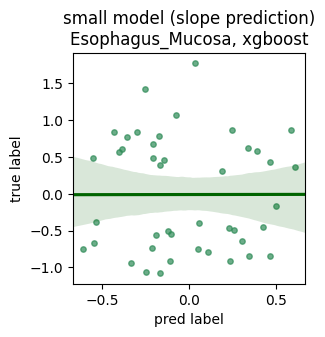

In [5]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [6]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 11}
{'num_leaves': 14}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.317574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284599
[LightGBM] [Info] Number of data points in the train set: 380, number of used features: 17920
[LightGBM] [Info] Start training from score -0.010266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


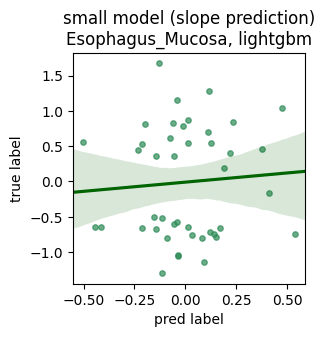

In [7]:
ml_model = model_list[1]

clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 157}
{'max_depth': 8}


rmse= 0.7251623944829841
r2= 0.058901829462044586
pcc= 0.265969681288705
pcc_p= 0.08472770806294502


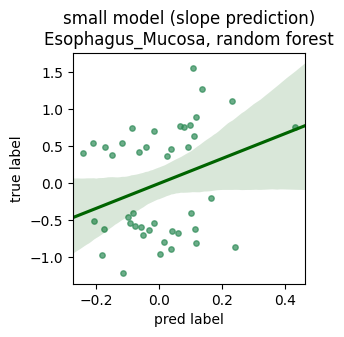

In [9]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)        

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

rmse= 0.7538480313707436
r2= -0.01702584748898639
pcc= -0.16842554489057332
pcc_p= 0.2803064688325098


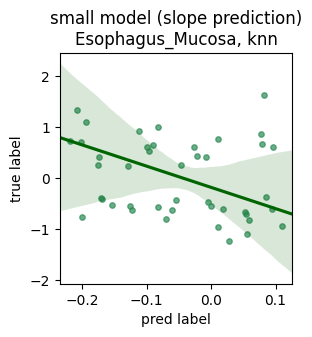

In [11]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)    

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [4]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.0001}
{'C': 0.0001}


rmse= 0.769560396522919
r2= -0.059863168011818235
pcc= nan
pcc_p= nan


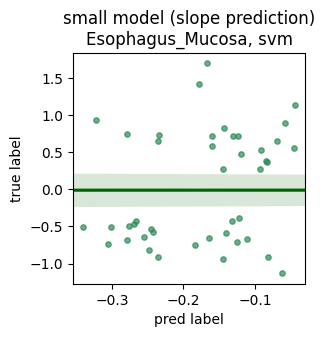

In [5]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [6]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

             variant_id     slope  \
0   chr1_959193_G_A_b38  0.456110   
1   chr1_989148_C_A_b38  0.651714   
2  chr1_1925307_C_A_b38  0.608696   
3  chr1_2493455_T_C_b38  0.540057   
4  chr1_3654319_C_T_b38  0.511822   

                                 enformer_pca_before  \
0  [[-83.627655, 63.805264, 48.713093, -2.1080363...   
1  [[-60.14403, 31.239855, 73.605675, -30.321785,...   
2  [[-7.6061993, -33.385612, 130.09674, 5.6361327...   
3  [[-65.294876, 8.857542, -16.338573, 52.5227, -...   
4  [[-27.129887, 1.1030134, 2.9368007, 0.14941776...   

                                  enformer_pca_after  
0  [[-84.26917, 63.011726, 48.734493, -2.0596538,...  
1  [[-60.108875, 31.23492, 73.560265, -30.374502,...  
2  [[-7.6092463, -33.386814, 130.1147, 5.6463146,...  
3  [[-65.295395, 8.847048, -16.34165, 52.48972, -...  
4  [[-27.133184, 1.0876479, 3.1341593, 0.12770882...  
X_train shape: (460, 17920)
Y_train shape: (460,)
X_test shape: (52, 17920)
Y_test shape: (52,)


##### model 1: xgboost

In [7]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 10}
{'max_depth': 7}


rmse= 0.7781550027823032
r2= -0.24778831152118896
pcc= -0.031145341679346693
pcc_p= 0.8265053561713669


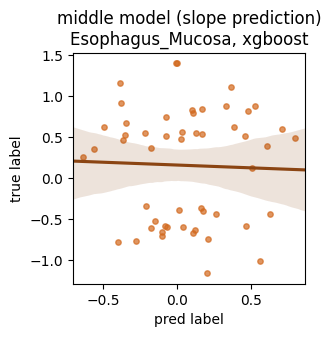

In [8]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [9]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 6}
{'num_leaves': 26}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2754860
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 17920
[LightGBM] [Info] Start training from score 0.040800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

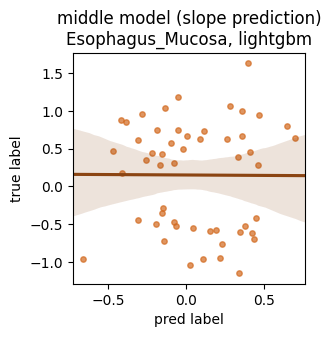

In [10]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 31}
{'max_depth': 8}


rmse= 0.6990572151509417
r2= -0.007010804899643119
pcc= 0.18286575262445123
pcc_p= 0.19443124630483977


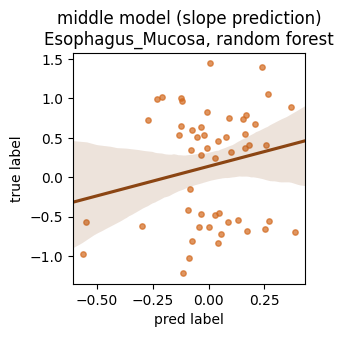

In [12]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

rmse= 0.712549049667513
r2= -0.046256612298981814
pcc= -0.05180757984043954
pcc_p= 0.7152955794895614


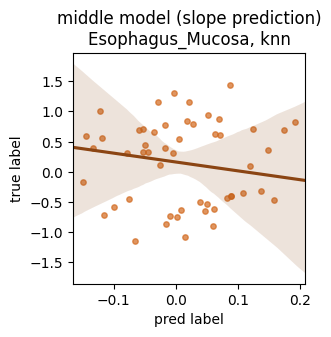

In [14]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [15]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.1}
{'C': 10}


rmse= 0.6948666584354237
r2= 0.005026228468303584
pcc= 0.1981067220530799
pcc_p= 0.15917904881288708


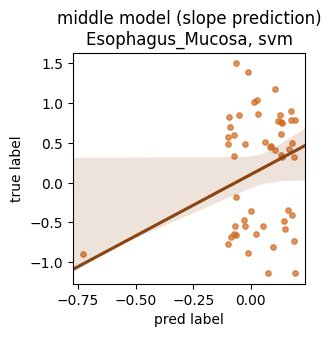

In [16]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [3]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

             variant_id     slope  \
0   chr1_841166_A_G_b38  0.291182   
1  chr1_1091327_C_A_b38  0.223220   
2  chr1_1655861_G_A_b38  1.664350   
3  chr1_2522989_T_C_b38  0.454298   
4  chr1_2522989_T_C_b38  0.507771   

                                 enformer_pca_before  \
0  [[-39.09846, 5.7203403, -27.636833, 20.905714,...   
1  [[229.02756, 63.724518, 23.077873, -76.382866,...   
2  [[-42.936413, 24.767908, -46.545135, 115.05509...   
3  [[-73.53031, 1.0609637, 5.599172, 39.998802, -...   
4  [[-73.53067, 1.0608888, 5.5992265, 39.998646, ...   

                                  enformer_pca_after  
0  [[-39.107323, 5.733504, -27.63229, 20.946554, ...  
1  [[229.03197, 63.65172, 23.1272, -76.38382, -47...  
2  [[-42.93101, 24.767063, -46.52511, 115.04314, ...  
3  [[-73.50203, 1.0306535, 5.6660266, 39.9275, -2...  
4  [[-73.50193, 1.030426, 5.6660624, 39.927433, -...  
X_train shape: (714, 17920)
Y_train shape: (714,)
X_test shape: (80, 17920)
Y_test shape: (80,)


##### model 1: xgboost

In [18]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 74}
{'max_depth': 6}


rmse= 0.804169897835268
r2= 0.009253911107042878
pcc= 0.2789913420573925
pcc_p= 0.012207959829116525


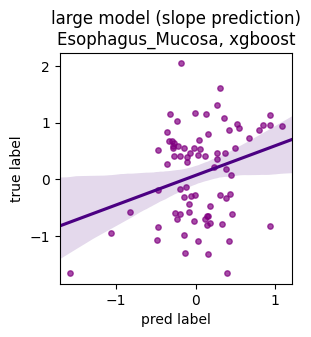

In [19]:
ml_model = model_list[0]
clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [20]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 28}
{'num_leaves': 26}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.396171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4270841
[LightGBM] [Info] Number of data points in the train set: 714, number of used features: 17920
[LightGBM] [Info] Start training from score 0.030267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
rmse= 0.775484068315524
r2= 0.07867575062341936
pcc= 0.32296517710779393
pcc_p= 0.0034783603523120222


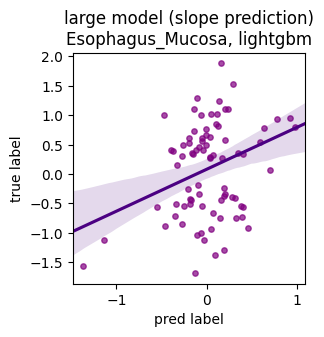

In [21]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 31}
{'max_depth': 8}


rmse= 0.7298842554916296
r2= 0.011481977737412996
pcc= 0.2203291492516433
pcc_p= 0.04954468472891231


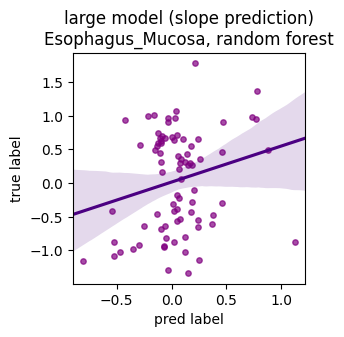

In [5]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

rmse= 0.744096872142646
r2= -0.02739053064212804
pcc= -0.08750471945640603
pcc_p= 0.4402150050037346


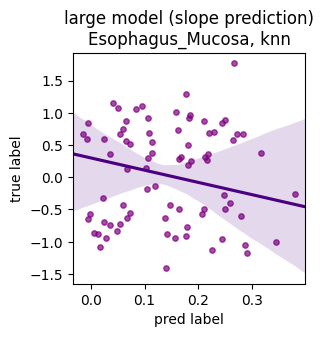

In [7]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.001}
{'C': 1000}


rmse= 0.7099139118756496
r2= 0.06483558094792075
pcc= 0.32867774996071664
pcc_p= 0.002913817536333674


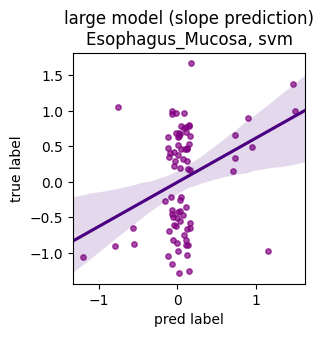

In [9]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()